# Linear Regression Example

This example analyzes the bike sharing data set, which contains information of how many bikes have been rented on specific days. In addition to the raw numbers, the data set also contains information about the weather and holidays.

Using a linear regression, we try to train a model which can be used to predict the number of bikes rented.

In [1]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Load Data from File

The data is stored in a CSV file. We first load every column as a String type and then we cast the columns into numeric data types. This approach prevents errors if contents cannot be interpreted as a number. In these cases columns will contain `NaN` values.

In [2]:
schema = StructType([
    StructField('row_id',StringType(),True),
    StructField('date',StringType(), True),
    StructField('season',StringType(), True),
    StructField('year',StringType(), True),
    StructField('month',StringType(), True),
    StructField('hour',StringType(), True),
    StructField('holiday',StringType(), True),
    StructField('weekday',StringType(), True),
    StructField('workingday',StringType(), True),
    StructField('weather',StringType(), True),
    StructField('temperature',StringType(), True),
    StructField('apparent_temperature',StringType(), True),
    StructField('humidity',StringType(), True),
    StructField('wind_speed',StringType(), True),
    StructField('casual',StringType(), True),
    StructField('registered',StringType(), True),
    StructField('counter',StringType(), True)
    ])

raw_data = spark.read \
    .schema(schema) \
    .csv('s3://dimajix-training/data/bike-sharing/hour_nohead.csv')

data = raw_data.select(
    raw_data.row_id.cast('int'),
    raw_data.date.cast('string'),
    unix_timestamp(raw_data.date, "yyyy-MM-dd").alias('ts'),
    raw_data.season.cast('double'),
    raw_data.year.cast('double'),
    raw_data.month.cast('double'),
    raw_data.hour.cast('double'),
    raw_data.holiday.cast('double'),
    raw_data.weekday.cast('double'),
    raw_data.workingday.cast('double'),
    raw_data.weather.cast('double'),
    raw_data.temperature.cast('double'),
    raw_data.apparent_temperature.cast('double'),
    raw_data.humidity.cast('double'),
    raw_data.wind_speed.cast('double'),
    raw_data.casual.cast('double'),
    raw_data.registered.cast('double'),
    raw_data.counter.cast('double')
    )

# Inspect Data

Now that we have loaded the data let's peek inside the DataFrame.

In [3]:
# Inspect first 10 entries of the DataFrame
data.limit(10).toPandas()

,row_id,date,ts,season,year,month,hour,holiday,weekday,workingday,weather,temperature,apparent_temperature,humidity,wind_speed,casual,registered,counter
0,1,2011-01-01,1293840000,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0
1,2,2011-01-01,1293840000,1.0,0.0,1.0,1.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,8.0,32.0,40.0
2,3,2011-01-01,1293840000,1.0,0.0,1.0,2.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,5.0,27.0,32.0
3,4,2011-01-01,1293840000,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0
4,5,2011-01-01,1293840000,1.0,0.0,1.0,4.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,0.0,1.0,1.0
5,6,2011-01-01,1293840000,1.0,0.0,1.0,5.0,0.0,6.0,0.0,2.0,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0
6,7,2011-01-01,1293840000,1.0,0.0,1.0,6.0,0.0,6.0,0.0,1.0,0.22,0.2727,0.80,0.0000,2.0,0.0,2.0
7,8,2011-01-01,1293840000,1.0,0.0,1.0,7.0,0.0,6.0,0.0,1.0,0.20,0.2576,0.86,0.0000,1.0,2.0,3.0
8,9,2011-01-01,1293840000,1.0,0.0,1.0,8.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,1.0,7.0,8.0
9,10,2011-01-01,1293840000,1.0,0.0,1.0,9.0,0.0,6.0,0.0,1.0,0.32,0.3485,0.76,0.0000,8.0,6.0,14.0


# Make some Pictures

Just t get a rough feeling about the data, we make some pictures of the number of rented bikes against the time.

First we need to import matplotlib.pyplot and also make all plots appear inline in the notebook

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

## Make a Plot of Rents per Day
The original data contains rents per hour, we want to have the data per day

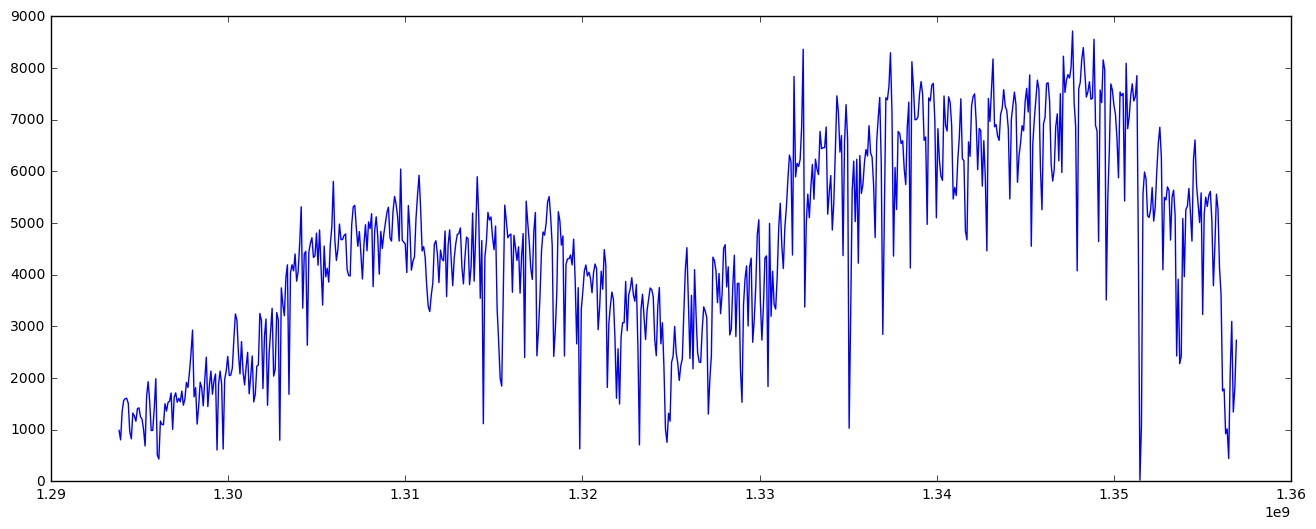

In [5]:
daily = data\
    .groupBy('ts').sum('counter') \
    .orderBy('ts')

# Convert to Pandas    
pdf = daily.toPandas()

# Make a Plot
plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf['ts'],pdf['sum(counter)'])

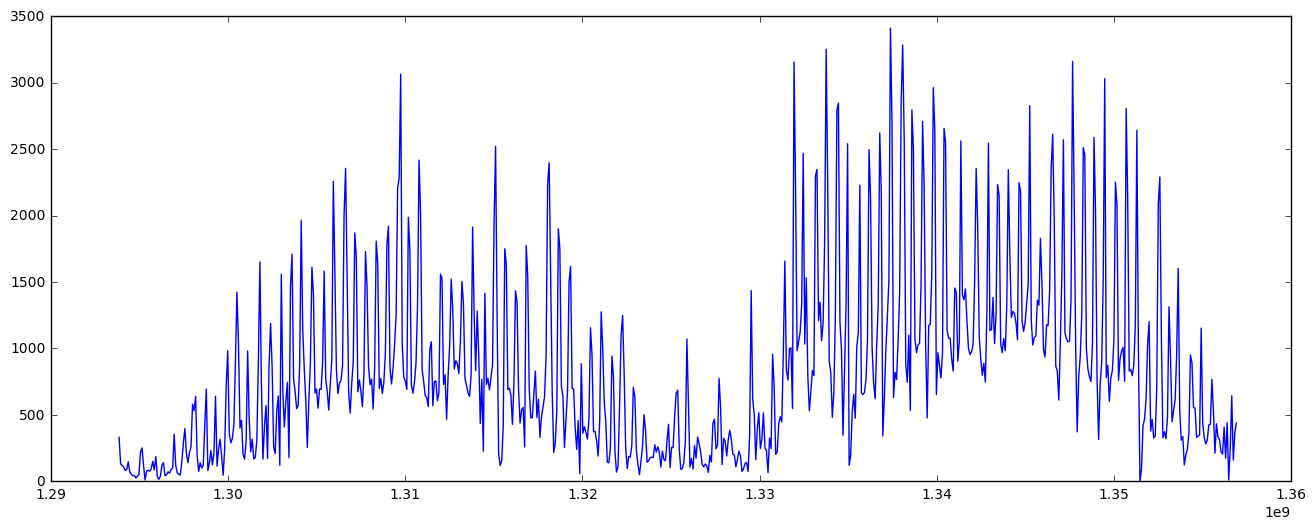

In [6]:
tmp = data \
    .groupBy('ts').sum('casual') \
    .orderBy('ts')
    
pdf = tmp.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf['ts'],pdf['sum(casual)'])

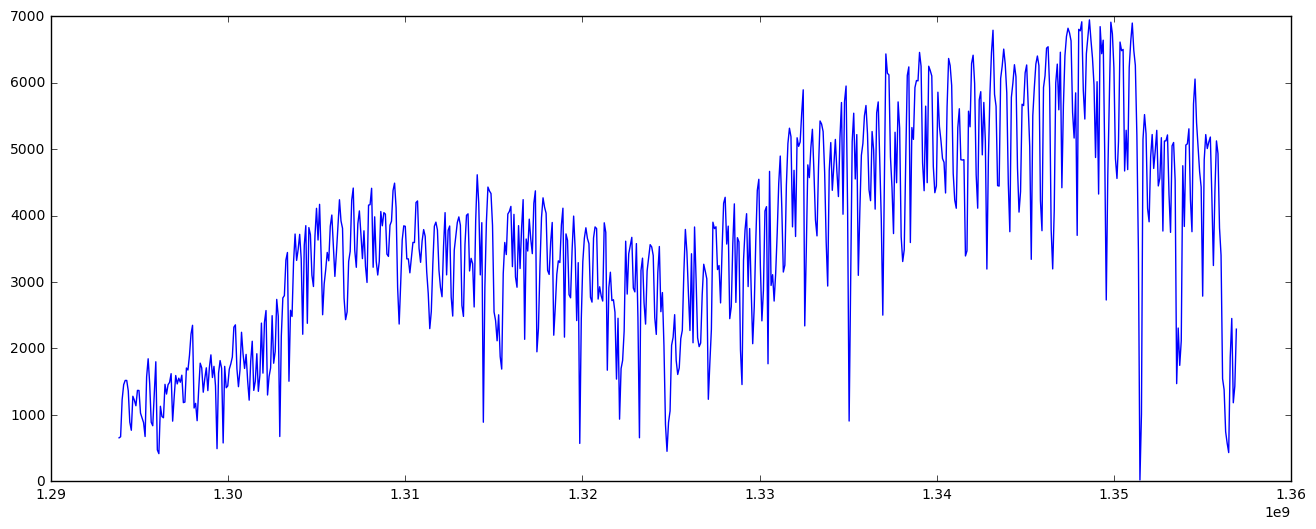

In [7]:
tmp = data \
    .groupBy('ts').sum('registered') \
    .orderBy('ts')
    
pdf = tmp.toPandas()

plt.figure(figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(pdf['ts'],pdf['sum(registered)'])    

# Use VectorAssembler

Most Spark ML methods require one feature column of type `Vector`. In order to generate this feature column from the raw data, Spark provides a `VectorAssembler` which assembles one feature column from arbitrary source columns. The source columns have to be of type `double`.

We use it to automatically extract the columns

    season, year, month, hour, holiday, weekday, workingday, weather, 
    temperature, apparent_temperature, humidity, wind_speed
    
into the new output column 'features'

In [8]:
from pyspark.ml.feature import *

tx = VectorAssembler(inputCols=['season','year','month','hour','holiday','weekday','workingday','weather','temperature','apparent_temperature','humidity','wind_speed'],outputCol='features')
td = tx.transform(data)

td.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- season: double (nullable = true)
 |-- year: double (nullable = true)
 |-- month: double (nullable = true)
 |-- hour: double (nullable = true)
 |-- holiday: double (nullable = true)
 |-- weekday: double (nullable = true)
 |-- workingday: double (nullable = true)
 |-- weather: double (nullable = true)
 |-- temperature: double (nullable = true)
 |-- apparent_temperature: double (nullable = true)
 |-- humidity: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- casual: double (nullable = true)
 |-- registered: double (nullable = true)
 |-- counter: double (nullable = true)
 |-- features: vector (nullable = true)



## Split Train and Test Data

Since we found an easier way to generate features, we split incoming data first and apply the VectorAssembler

In [10]:
train_data, test_data = data.randomSplit([0.8,0.2], seed=0)
print(train_data.count())
print(test_data.count())

13898
3481


## Perform Regression

1. Apply VectorAssembler
2. Perform Fitting

In [12]:
from pyspark.ml.regression import *

asm = VectorAssembler(inputCols=['season','year','month','hour','holiday','weekday','workingday','weather','temperature','apparent_temperature','humidity','wind_speed'],outputCol='features')
regression = LinearRegression(featuresCol='features', labelCol='counter', predictionCol='prediction')
model = regression.fit(asm.transform(train_data))

## Predict

Make predictions from test data and print some results. We use the `test_data` DataFrame (which was not used during training). Since this DataFrame does not already contain the feature column, we also need to apply the previously configured `VectorAssembler`.

In [13]:
# Create features using the VectorAssembler
test_features = asm.transform(test_data)

# Transform the resulting DataFrame using the trained model
prediction = model.transform(test_features)

# Print result
prediction.limit(10).toPandas()

,row_id,date,ts,season,year,month,hour,holiday,weekday,workingday,weather,temperature,apparent_temperature,humidity,wind_speed,casual,registered,counter,features,prediction
0,1,2011-01-01,1293840000,1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0000,3.0,13.0,16.0,"[1.0, 0.0, 1.0, 0.0, 0.0, 6.0, 0.0, 1.0, 0.24,...",-74.033424
1,4,2011-01-01,1293840000,1.0,0.0,1.0,3.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.75,0.0000,3.0,10.0,13.0,"[1.0, 0.0, 1.0, 3.0, 0.0, 6.0, 0.0, 1.0, 0.24,...",-39.247284
2,6,2011-01-01,1293840000,1.0,0.0,1.0,5.0,0.0,6.0,0.0,2.0,0.24,0.2576,0.75,0.0896,0.0,1.0,1.0,"[1.0, 0.0, 1.0, 5.0, 0.0, 6.0, 0.0, 2.0, 0.24,...",-29.845678
3,23,2011-01-01,1293840000,1.0,0.0,1.0,22.0,0.0,6.0,0.0,2.0,0.40,0.4091,0.94,0.2239,11.0,17.0,28.0,"[1.0, 0.0, 1.0, 22.0, 0.0, 6.0, 0.0, 2.0, 0.4,...",118.692268
4,24,2011-01-01,1293840000,1.0,0.0,1.0,23.0,0.0,6.0,0.0,2.0,0.46,0.4545,0.88,0.2985,15.0,24.0,39.0,"[1.0, 0.0, 1.0, 23.0, 0.0, 6.0, 0.0, 2.0, 0.46...",157.216427
5,27,2011-01-02,1293926400,1.0,0.0,1.0,2.0,0.0,0.0,0.0,2.0,0.42,0.4242,1.00,0.2836,1.0,8.0,9.0,"[1.0, 0.0, 1.0, 2.0, 0.0, 0.0, 0.0, 2.0, 0.42,...",-52.010749
6,28,2011-01-02,1293926400,1.0,0.0,1.0,3.0,0.0,0.0,0.0,2.0,0.46,0.4545,0.94,0.1940,2.0,4.0,6.0,"[1.0, 0.0, 1.0, 3.0, 0.0, 0.0, 0.0, 2.0, 0.46,...",-26.461982
7,32,2011-01-02,1293926400,1.0,0.0,1.0,8.0,0.0,0.0,0.0,3.0,0.40,0.4091,0.71,0.2239,0.0,8.0,8.0,"[1.0, 0.0, 1.0, 8.0, 0.0, 0.0, 0.0, 3.0, 0.4, ...",38.376006
8,39,2011-01-02,1293926400,1.0,0.0,1.0,15.0,0.0,0.0,0.0,3.0,0.34,0.3333,0.81,0.1642,19.0,55.0,74.0,"[1.0, 0.0, 1.0, 15.0, 0.0, 0.0, 0.0, 3.0, 0.34...",48.365339
9,41,2011-01-02,1293926400,1.0,0.0,1.0,17.0,0.0,0.0,0.0,1.0,0.34,0.3333,0.57,0.1940,7.0,58.0,65.0,"[1.0, 0.0, 1.0, 17.0, 0.0, 0.0, 0.0, 1.0, 0.34...",120.024088


## Evaluation

Finally lets evaluate the prediction

In [15]:
from pyspark.ml.evaluation import *

evaluator = RegressionEvaluator(predictionCol='prediction', labelCol='counter', metricName='rmse')
print(evaluator.evaluate(prediction))

141.87649998088213


# Adding More Features

We might want to add more features in order to improve prediction quality. We propose the following additional features:

1. Features for modelling period effects of a year. This can be done by adding the two features:
        sin(ts / 31536000 * 6.28318531) 
        cos(ts / 31536000 * 6.28318531)
2. Similarily for modelling periodic effects within a week, the following features can be used:
        sin(weekday / 7 * 6.28318531)
        cos(weekday / 7 * 6.28318531)
3. And for modelling periodic effects within a single day the following features can be used:
        sin(hour / 24 * 6.28318531)
        cos(hour / 24 * 6.28318531)
4. season, one-hot encoded
5. weather, one-hot encoded

You can use SQLTransformer for arithmetic transformations and a combination of

    StringIndexer(inputCol='categoricalFeature', outputCol='categoricalIndex')
    OneHotEncoder(inputCol='categoricalIndex', outputCol='categoricalOneHot')
    
for creating one hot encoded categorical features.

We now have a lot of transformations, all of them need to be applied to both the training data and also to the test data. A `Pipeline` can be used to encapsulate multiple feature extraction and model training steps into a single object, which will train also a single pipeline model.

In [17]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages= [
    SQLTransformer(statement="""
        SELECT 
            *,
            sin(ts / 31536000 * 6.28318531) as ts_sin,
            cos(ts / 31536000 * 6.28318531) ts_cos, 
            sin(weekday / 7 * 6.28318531) as wd_sin, 
            cos(weekday / 7 * 6.28318531) as wd_cos,
            sin(hour / 24 * 6.28318531) as hour_sin, 
            cos(hour / 24 * 6.28318531) as hour_cos 
        FROM __THIS__
    """),
    StringIndexer(inputCol='season',outputCol='iseason'),
    OneHotEncoder(inputCol='iseason',outputCol='vseason'),
    StringIndexer(inputCol='weather',outputCol='iweather'),
    OneHotEncoder(inputCol='iweather',outputCol='vweather'),
    VectorAssembler(inputCols=['ts_sin','ts_cos','wd_sin','wd_cos','hour_sin','hour_cos','year','month','hour','holiday','weekday','workingday','temperature','apparent_temperature','humidity','wind_speed','vseason'],outputCol='features'),
    LinearRegression(featuresCol='features', labelCol='counter', predictionCol='prediction'),
])

pipeline_model = pipeline.fit(train_data)

In [18]:
# Transform the test_data DataFrame using the trained pipeline model
prediction = pipeline_model.transform(test_data)

# Evlaute pipeline model
print(evaluator.evaluate(prediction))

127.2216931648836
